In [1]:
import string

import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.adamw import AdamW

from tqdm import tqdm
tqdm.pandas()

import pandas as pd
import numpy as np

from fastprogress import master_bar, progress_bar



## load data

In [2]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab/ethnicolor/data/fl_2022_FullName_train.csv.gz")
val_df = pd.read_csv("/content/drive/MyDrive/Colab/ethnicolor/data/fl_2022_FullName_val.csv.gz")
test_df = pd.read_csv("/content/drive/MyDrive/Colab/ethnicolor/data/fl_2022_FullName_test.csv.gz")

In [3]:
train_df.head()

,name_last,name_first,race,full_name,race_code
0,Baxla,Phyllis,nh_white,Baxla Phyllis,0
1,Ludwin,Ron,nh_white,Ludwin Ron,0
2,Signer Welton,Jessica,nh_white,Signer Welton Jessica,0
3,Stamps,Joshua,nh_white,Stamps Joshua,0
4,Vassell,Lillie,nh_black,Vassell Lillie,1


## Creating Dataset

In [4]:
all_letters = string.ascii_letters + "'- "

In [5]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'- "

In [6]:
n_letters = len(all_letters)

In [7]:
n_letters

55

In [8]:
race_id_df = train_df[['race', 'race_code']].drop_duplicates().sort_values('race_code')
race_to_id = dict(race_id_df.values)

In [9]:
race_to_id

{'nh_white': 0, 'nh_black': 1, 'other': 2, 'hispanic': 3, 'asian': 4}

In [10]:
id_to_race = dict(race_id_df[['race_code', 'race']].values)

In [11]:
all_categories = list(id_to_race.values())

In [12]:
all_categories

['nh_white', 'nh_black', 'other', 'hispanic', 'asian']

In [13]:
n_categories = len(train_df['race_code'].unique())

In [14]:
n_categories

5

In [15]:
max_name = train_df['full_name'].str.len().max()

In [16]:
oob = n_letters + 1

In [17]:
def letterToIndex(letter):
    return all_letters.find(letter)

In [18]:
def lineToTensor(line):
    tensor = torch.ones(max_name) * oob
    for li, letter in enumerate(line):
        tensor[li] = letterToIndex(letter)
    return tensor

In [19]:
lineToTensor('Jason')

tensor([35.,  0., 18., 14., 13., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])

In [20]:
print(lineToTensor('Jason').size())

torch.Size([47])


In [21]:
def getTarget(label):
  target = n_categories * [0]
  target[label] = 1
  return target

In [22]:
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

class EthniColorDataset(Dataset):
  def __init__(self, data_df, transform=None):
    self.df = data_df
    self.transform = transform
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    name = self.df.iloc[idx, 3]
    if self.transform:
      name = self.transform(name)
    label = self.df.iloc[idx, 4]
    #target = getTarget(label)
    target = torch.tensor(label, dtype=torch.int64)
    return name, target

In [23]:
train_dataset = EthniColorDataset(train_df, lineToTensor)
val_dataset = EthniColorDataset(val_df, lineToTensor)
test_dataset = EthniColorDataset(test_df, lineToTensor)

In [24]:
for i in range(3):
  name, label = train_dataset[i]
  print(i, name, label)

0 tensor([27.,  0., 23., 11.,  0., 54., 41.,  7., 24., 11., 11.,  8., 18., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.]) tensor(0)
1 tensor([37., 20.,  3., 22.,  8., 13., 54., 43., 14., 13., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.]) tensor(0)
2 tensor([44.,  8.,  6., 13.,  4., 17., 54., 48.,  4., 11., 19., 14., 13., 54.,
        35.,  4., 18., 18.,  8.,  2.,  0., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.]) tensor(0)


In [25]:
# The Dataset retrieves our dataset’s features and labels one sample at a time. 
# While training a model, we typically want to pass samples in “minibatches”, 
# reshuffle the data at every epoch to reduce model overfitting, and 
# use Python’s multiprocessing to speed up data retrieval.

batch_size=128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=12)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=12)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=12)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [26]:
next(iter(train_dataloader))

[tensor([[27., 11.,  0.,  ..., 56., 56., 56.],
         [43.,  0., 12.,  ..., 56., 56., 56.],
         [32., 17.,  0.,  ..., 56., 56., 56.],
         ...,
         [31., 11.,  4.,  ..., 56., 56., 56.],
         [28., 14., 14.,  ..., 56., 56., 56.],
         [39., 14., 17.,  ..., 56., 56., 56.]]),
 tensor([3, 2, 1, 3, 2, 3, 1, 0, 0, 0, 1, 0, 0, 3, 0, 1, 0, 2, 0, 1, 3, 0, 3, 0,
         3, 0, 0, 2, 3, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 3, 0, 0, 1, 0, 3,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 3, 1, 0, 0, 0, 0, 3, 1,
         0, 0, 0, 3, 1, 3, 1, 1, 0, 0, 2, 0, 1, 3, 3, 0, 3, 0, 0, 3, 0, 1, 2, 0,
         0, 0, 1, 0, 0, 3, 0, 3, 1, 0, 0, 0, 1, 0, 2, 0, 0, 3, 0, 0, 3, 0, 1, 0,
         3, 0, 0, 1, 0, 0, 1, 1])]

In [27]:
for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched[0].size(), sample_batched[1].size())
    if i_batch == 2:
        break

0 torch.Size([128, 47]) torch.Size([128])
1 torch.Size([128, 47]) torch.Size([128])
2 torch.Size([128, 47]) torch.Size([128])


In [28]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [29]:
import math 

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


In [30]:
# Set the random seed for reproducible results
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the Transformer model
class Transformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, nhead, num_layers=1):
        super(Transformer, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.pos_encoder = PositionalEncoding(hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        embedded = self.embedding(input.type(torch.IntTensor).to(input.device))
        pos_encoded = self.pos_encoder(embedded)
        out = self.transformer_encoder(pos_encoded) # (batch, seq, feature)
        out = out[:, -1, :] # drop seq
        out = self.fc(out)
        out = self.softmax(out) # (batch, out_cats)
        return out

n_hidden = 256 # 128
seq_len = max_name 
vocab_size = n_letters + 2

model = Transformer(vocab_size, n_hidden, n_categories, nhead=4, num_layers=2)
model.to(device)

Transformer(
  (embedding): Embedding(57, 256)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [31]:
input = lineToTensor('Rogers Renee')

print("input shape : ",input.shape)
print("input shape w batch : ", input.unsqueeze(0).shape)
#print(hidden.shape)

# sending with batch 1
output = model(input.unsqueeze(0).to(device))
# print(output) - has 47x8 log values
print(output.shape)

input shape :  torch.Size([47])
input shape w batch :  torch.Size([1, 47])
torch.Size([1, 5])


In [ ]:
output

tensor([[-1.7753, -1.5949, -1.7535, -1.2040, -1.8678]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

In [ ]:
torch.argmax(output)

tensor(3, device='cuda:0')

In [ ]:
a = torch.zeros(1, 2, 3, 4, 5, 6)
b = a.view(*a.shape[:2], -1, *a.shape[5:])
print(a.shape)
print(b.shape)

torch.Size([1, 2, 3, 4, 5, 6])
torch.Size([1, 2, 60, 6])


In [ ]:
a = torch.zeros(1,47,53,64)
b = a.view(a.shape[0],-1,a.shape[3])
print(a.shape)
print(b.shape)
c = torch.zeros([1, 2491, 256])
d = c.view(c.shape[0],47,53,c.shape[2])
print(d.shape)

torch.Size([1, 47, 53, 64])
torch.Size([1, 2491, 64])
torch.Size([1, 47, 53, 256])


In [ ]:
top_n, top_i = output.topk(1)

In [ ]:
output

tensor([[-1.7753, -1.5949, -1.7535, -1.2040, -1.8678]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

In [ ]:
top_n

tensor([[-1.2040]], device='cuda:0', grad_fn=<TopkBackward0>)

In [ ]:
top_n # has log values
top_i # has indices

tensor([[3]], device='cuda:0')

In [ ]:
# to get best value
top_n, top_i = output.topk(1)
category_i = top_i[0].item()
all_categories[category_i], category_i

('asian', 3)

## Training


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
!lscpu | grep -i cpu

CPU op-mode(s):                  32-bit, 64-bit
CPU(s):                          8
On-line CPU(s) list:             0-7
CPU family:                      6
Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
CPU MHz:                         2000.136
NUMA node0 CPU(s):               0-7
Flags:                           fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities


In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

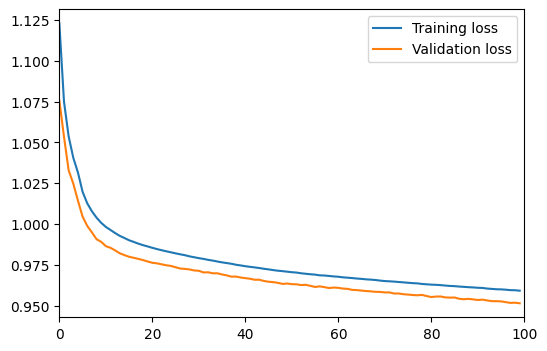

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


Validation loss decreased (inf --> 1.075629).  Saving model ...


/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Validation loss decreased (1.075629 --> 1.053467).  Saving model ...
Validation loss decreased (1.053467 --> 1.032933).  Saving model ...
Validation loss decreased (1.032933 --> 1.024750).  Saving model ...
Validation loss decreased (1.024750 --> 1.014299).  Saving model ...
Validation loss decreased (1.014299 --> 1.004527).  Saving model ...
Validation loss decreased (1.004527 --> 0.998844).  Saving model ...
Validation loss decreased (0.998844 --> 0.994877).  Saving model ...
Validation loss decreased (0.994877 --> 0.990693).  Saving model ...
Validation loss decreased (0.990693 --> 0.989061).  Saving model ...
Validation loss decreased (0.989061 --> 0.986434).  Saving model ...
Validation loss decreased (0.986434 --> 0.985404).  Saving model ...
Validation loss decreased (0.985404 --> 0.983823).  Saving model ...
Validation loss decreased (0.983823 --> 0.982042).  Saving model ...
Validation loss decreased (0.982042 --> 0.980926).  Saving model ...
Validation loss decreased (0.98092

In [ ]:
epochs = 100
lr = 0.0001 # 0.005 is very slow


# CrossEntropyLoss expects raw prediction values while NLLLoss expects log probabilities.
# criterion = nn.CrossEntropyLoss() # nn.NLLLoss()
# since we are using nn.LogSoftmax as final layer at model  
criterion = nn.NLLLoss()

#optimizer = AdamW(model.parameters(), lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

early_stopper = EarlyStopper(patience=5)

mb = master_bar(range(epochs))
mb.names = ['Training loss', 'Validation loss']

x = []
training_losses = []
validation_losses = []

valid_mean_min = np.Inf

till_batch = 100

for epoch in mb:
  x.append(epoch)
  # Train
  i = 0
  model.train()
  total_loss = torch.Tensor([0.0]).to(device)
  for batch in progress_bar(train_dataloader, parent=mb):
    model.zero_grad()
    input = batch[0].to(device)
    label = batch[1].to(device)
    output = model(input)
    loss = criterion(output, label)
    # backward propagation
    loss.backward()
    optimizer.step()
    with torch.no_grad():
      total_loss += loss.item()
    i += 1
    #if i == till_batch:
    #  break

  # decay lr
  # scheduler.step()

  mean = total_loss / len(train_dataloader)
  #mean = total_loss / till_batch
  training_losses.append(mean.cpu())

  # Evaluate
  i = 0
  model.eval()
  validation_loss = torch.Tensor([0.0]).to(device)
  with torch.no_grad():
    for batch in progress_bar(val_dataloader, parent=mb):
      input = batch[0].to(device)
      label = batch[1].to(device)
      output = model(input)
      loss = criterion(output, label)
      validation_loss += loss.item()
      i += 1
      #if i == till_batch:
      #  break

  val_mean = validation_loss / len(val_dataloader)
  #val_mean = validation_loss / till_batch

  validation_losses.append(val_mean.cpu())
  # Update training chart
  mb.update_graph([[x, training_losses], [x, validation_losses]], [0,epochs])
  mb.write(f"\nEpoch {epoch}: Training loss {mean.item():.6f} validation loss {val_mean.item():.6f} with lr {lr:.6f}")
  # save model if validation loss has decreased
  if val_mean.item() <= valid_mean_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_mean_min,
      val_mean.item()))
      torch.save(model.state_dict(), '/content/drive/MyDrive/Colab/ethnicolor/transformer_fullname.pt')
      valid_mean_min = val_mean.item()

  if early_stopper.early_stop(val_mean.item()):             
        break

## Save Model

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab/ethnicolor/transformer_fullname_after_train.pt')

In [33]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab/ethnicolor/models/transformer_FullName_pytorch_66_acc.pt'))

<All keys matched successfully>

In [34]:
criterion = nn.NLLLoss()

## Testing

In [35]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [36]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# track test loss
test_loss = 0.0


class_correct = list(0. for i in range(n_categories))
class_total = list(0. for i in range(n_categories))


actual = []
predictions = []

model.eval()
# iterate over test data
pbar = tqdm(test_dataloader, total=len(test_dataloader), position=0, desc="Testing", leave=True)
for batch in pbar:
    # move tensors to GPU if CUDA is available
    input = batch[0].to(device)
    label = batch[1].to(device)
    output = model(input)
    loss = criterion(output, label)
    test_loss += loss.item()
    pred = torch.argmax(output, dim=1)
    correct_tensor = pred.eq(label.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(label.shape[0]):
        l = label.data[i]
        class_correct[l.long()] += correct[i].item()
        class_total[l.long()] += 1
        # for confusion matrix    
        actual.append(all_categories[label.data[i].item()])
        predictions.append(all_categories[pred.data[i].item()])


# plot confusion matrix
cm = confusion_matrix(actual, predictions, labels=all_categories)
print(classification_report(actual, predictions))

Testing:   0%|          | 0/7498 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Testing: 100%|██████████| 7498/7498 [02:36<00:00, 47.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarnin

              precision    recall  f1-score   support

       asian       0.62      0.09      0.16     27824
    hispanic       0.66      0.51      0.57    169041
    nh_black       0.49      0.04      0.07    149283
    nh_white       0.66      0.94      0.78    573408
       other       0.00      0.00      0.00     40188

    accuracy                           0.66    959744
   macro avg       0.49      0.32      0.32    959744
weighted avg       0.61      0.66      0.58    959744



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


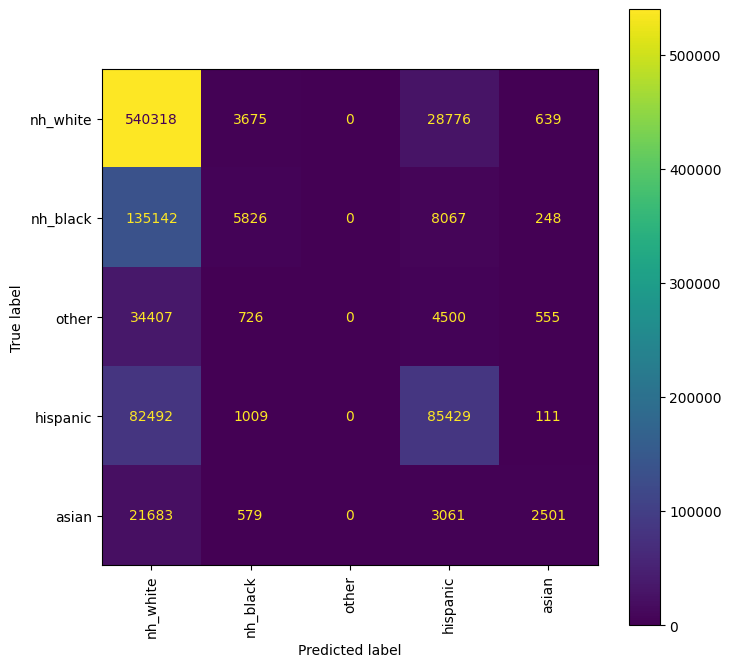

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline  

cmp = ConfusionMatrixDisplay(cm, display_labels=all_categories)
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')

In [38]:
# average test loss
test_loss = test_loss/len(test_dataloader)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(all_categories)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            all_categories[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (all_categories[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.951637

Test Accuracy of nh_white: 94% (540318/573408)
Test Accuracy of nh_black:  3% (5826/149283)
Test Accuracy of other:  0% ( 0/40188)
Test Accuracy of hispanic: 50% (85429/169041)
Test Accuracy of asian:  8% (2501/27824)

Test Accuracy (Overall): 66% (634074/959744)


In [39]:
name = "Ward Stephanie"
name_tokens = lineToTensor(name)
inp = name_tokens
print(inp.shape)
out = model(inp.unsqueeze(0).to(device))
print(out.shape)
out = torch.argmax(out)
print(out)
print(all_categories[out.item()])

torch.Size([47])
torch.Size([1, 5])
tensor(0, device='cuda:0')
nh_white
